# Analyze simulated cross-over trial with BAMBI
## Load packages

In [1]:
import pandas as pd
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import seaborn as sns

## Load simulated data from CSV file stored on GitHub

In [2]:
csv_url = 'https://raw.githubusercontent.com/haripen/Bambi_Analysis/main/sim_xover.csv'
df = pd.read_csv(csv_url,index_col=0,header=0)
# ensure correct data format handling later on
cats = ['id','try','test','treatment','sequence','period','value']
for dog in cats:
    df[dog] = df[dog].astype('category')
df['value'] = df['value'].astype('float64')
df.describe(include='all')

,id,try,test,treatment,sequence,period,value
count,240.0,240.0,240.0,240,240,240.0,240.000000
unique,20.0,3.0,2.0,2,2,2.0,NaN
top,1.0,1.0,1.0,C,TC,1.0,NaN
freq,12.0,80.0,120.0,120,144,120.0,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,2.575675
std,NaN,NaN,NaN,NaN,NaN,NaN,19.999950
min,NaN,NaN,NaN,NaN,NaN,NaN,-55.597187
25%,NaN,NaN,NaN,NaN,NaN,NaN,-11.239476
50%,NaN,NaN,NaN,NaN,NaN,NaN,2.468303
75%,NaN,NaN,NaN,NaN,NaN,NaN,17.041056


## A quick look at the simulated cross-over design data
- AB/BA design, here, TC/CT (seqzence: treatment-control/control-treatment)
- Two tests (1,2) with three tries (1,2,3) each
- period 1: post measurment (day 2) - pre mesurement (day 1), either treatment T or control C
- period 2: post measurment (day 4) - pre mesurement (day 2), either treatment T or control C

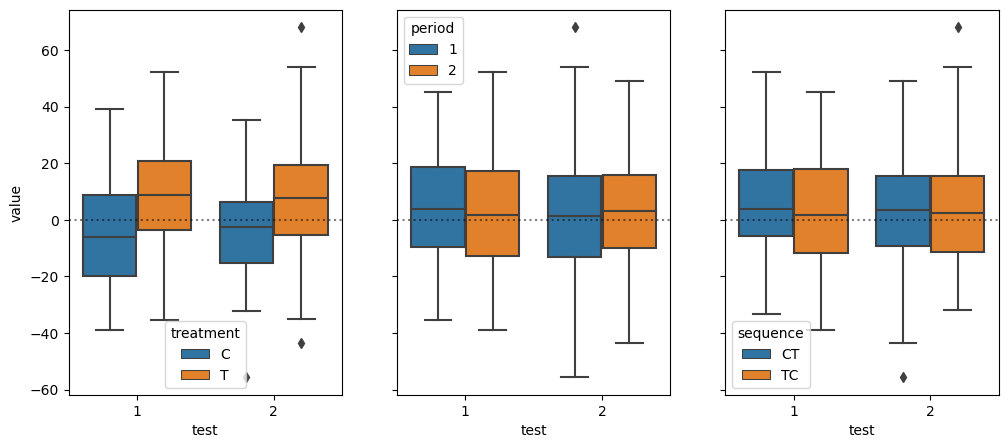

In [3]:
fig,axs=plt.subplots(1,3,figsize=(12,5),sharey=True,)
sns.boxplot(data=df,x='test',y='value',hue='treatment',ax=axs[0])
sns.boxplot(data=df,x='test',y='value',hue='period',ax=axs[1])
sns.boxplot(data=df,x='test',y='value',hue='sequence',ax=axs[2])
axs[0].axhline(y=0, color='black', linestyle=':',alpha=0.5)
axs[1].axhline(y=0, color='black', linestyle=':',alpha=0.5)
axs[2].axhline(y=0, color='black', linestyle=':',alpha=0.5)
axs[1].set_ylabel('')
axs[2].set_ylabel('')
plt.show()

## Fit a Bambi generalized linear mixed effects model

In [4]:
formula =  "value ~ sequence + period + treatment + (1|id:test)"
model = bmb.Model(formula=formula, data=df,
                  categorical=['treatment', 'sequence', 'period', 'id'],
                  family = 'gaussian',link="identity"
                 )
result = model.fit(tune = 1000, draws=2000, chains=4, target_accept=.85, random_seed=1234)
az.summary(result).head(4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, sequence, period, treatment, 1|id:test_sigma, 1|id:test_offset, value_sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 34 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-4.217,2.919,-9.596,1.325,0.027,0.023,11859.0,5419.0,1.0
sequence[TC],-0.043,2.656,-4.944,5.013,0.025,0.032,11535.0,6140.0,1.0
period[2],1.314,2.525,-3.361,6.089,0.022,0.027,13690.0,5885.0,1.0
treatment[T],12.337,2.517,7.448,16.902,0.022,0.016,13026.0,5733.0,1.0


## Prior and posterior predictive checks

Sampling: [1|id:test_offset, 1|id:test_sigma, Intercept, period, sequence, treatment, value, value_sigma]
/opt/anaconda3/envs/bambi091/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


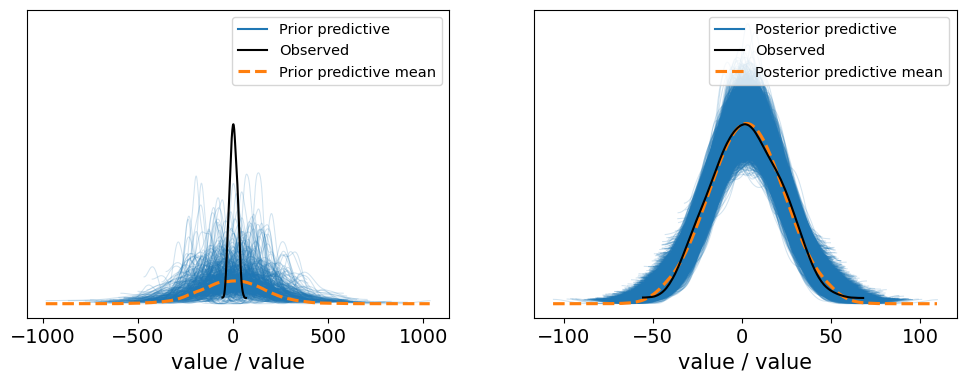

In [5]:
idata = model.prior_predictive(random_seed=1234)
idata.extend( model.predict(result, inplace=False, kind="pps") )
fig, axs = plt.subplots(1,2,figsize=(12,4),sharey=True)
az.plot_ppc(idata, group='prior',random_seed=1234,ax=axs[0])
az.plot_ppc(idata, group='posterior',random_seed=1234,ax=axs[1])
axs[1].set_ylabel('')
plt.show()

### How do I show the prior and posterior predictive checks for variables and leves?
References:
 - https://arviz-devs.github.io/arviz/api/generated/arviz.plot_ppc.html#arviz.plot_ppc
 - https://static-content.springer.com/esm/art%3A10.1038%2Fs41562-021-01177-7/MediaObjects/41562_2021_1177_MOESM1_ESM.pdf

In [6]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Nov 15 2022

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.6.0

seaborn   : 0.12.1
matplotlib: 3.6.2
bambi     : 0.9.1
arviz     : 0.13.0
pandas    : 1.5.1

Watermark: 2.3.1

